In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import tqdm
from torchsummary import summary

## Login Wandb

In [2]:
import wandb

## Prepare dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', 
                                      download=True,
                                      train=True,
                                      transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=32,
                                          shuffle=True)
test_set = torchvision.datasets.MNIST(root='./data',
                                     download=True,
                                     train=False,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size=32,
                                         shuffle=False)

## Build model

In [4]:
class Net(nn.Module):
    def __init__(self, n_classes=10):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, n_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # Flatten
        x = x.view(-1, 7*7*32)
        x = self.fc(x)
        return x

In [5]:
model = Net()
model

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [13]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.11
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


## Training

In [6]:
wandb.init(project='mnist-pytorch', entity='huynth18', reinit=True)

wandb: Currently logged in as: huynth18 (use `wandb login --relogin` to force relogin)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for i, data in enumerate(train_loader, 0):
        inputs = data[0].cpu()
        labels = data[1].cpu()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        
        
        if i%2000 == 0:
            print('Epoch: [{}/{}]\tLoss: {:.4f}'.format(epoch+1, EPOCHS, loss.item()))
            wandb.log({'epoch': epoch+1, 'loss': loss.item()})
            wandb.watch(model, criterion, log='all')
torch.save(model, 'model.pth')

Epoch: [1/20]	Loss: 0.1829
Epoch: [2/20]	Loss: 0.0206
Epoch: [3/20]	Loss: 0.0717
Epoch: [4/20]	Loss: 0.1108
Epoch: [5/20]	Loss: 0.0277
Epoch: [6/20]	Loss: 0.1675
Epoch: [7/20]	Loss: 0.1189
Epoch: [8/20]	Loss: 0.0124
Epoch: [9/20]	Loss: 0.0652
Epoch: [10/20]	Loss: 0.0066
Epoch: [11/20]	Loss: 0.0346
Epoch: [12/20]	Loss: 0.0134
Epoch: [13/20]	Loss: 0.0058
Epoch: [14/20]	Loss: 0.0801
Epoch: [15/20]	Loss: 0.0898
Epoch: [16/20]	Loss: 0.0347
Epoch: [17/20]	Loss: 0.0116
Epoch: [18/20]	Loss: 0.0056
Epoch: [19/20]	Loss: 0.0109


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [20/20]	Loss: 0.0159


AttributeError: Can't pickle local object 'TorchHistory.add_log_hooks_to_pytorch_module.<locals>.<lambda>'

## Test

In [13]:
to_pil = transforms.ToPILImage()

my_table = wandb.Table()

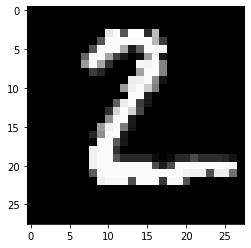

In [24]:
batch_iter = iter(test_loader)
images, labels = next(batch_iter)
img = to_pil(images[1])
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

In [30]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader:
        images = images.cpu()
        labels = labels.cpu()
        
#         my_table.add_column('label', labels)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
#         my_table.add_column("class_prediction", preds)

        # Log your Table to W&B
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
    print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
    
#     wandb.log({"mnist_predictions": my_table})
    wandb.log({"test_accuracy": correct / total})
    
    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

Accuracy of the model on the 10000 test images: 99.0%


In [42]:
wandb.

AttributeError: module 'wandb' has no attribute 'close'